# このノートでやった（できる）こと
### Logistic regressionを用いて、目的変数の確率を算出し、算出した値を元に様々な掛け方をした場合の回収率を計算

#### 計算に用いた特徴量
- 各レーサーのクラス
- 各レーサーの各枠における平均スタートタイム
- 各レーサーの連帯率
- 展示タイム
- 各モーターの2連率
- 各モーターの3連率
- 各ボートの2連率
- 各ボートの3連率

#### 目的変数
- 1枠: 1着になる (1) or ならない (0)
- 2-6枠: 3着以内にはいる (1) or 入らない (0)


### 結果
#### RandomForest classification結果
- XXX
- XXX
#### bet結果


In [1]:
# 必要なモジュールのインポート

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import termcolor
from datetime import datetime

import sys
import os

current_dir = os.getcwd()
sys.path.append(os.path.join(current_dir, '../conf/'))
sys.path.append(os.path.join(current_dir, '../crawl/'))
sys.path.append(os.path.join(current_dir, '../data_preparing/'))
sys.path.append(os.path.join(current_dir, 'analyzer_conf/'))

# my module
import loader
import boatrace_crawler_conf
import analyzer_conf

In [2]:
# 過去のレース結果をdfとして取得
the_merged_df = loader.main()
# dfをソート
the_merged_df = the_merged_df.sort_values(["date", "venue", "raceNumber"])
# print(the_merged_df["CS_frame_1_1"])

/Users/grice/mywork/boatrace/src/analyze/../data_preparing/loader.py:357: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  race_results_supplementary_df = pd.concat(race_results_supplementary_df_list)


In [3]:
"""

# test用にdfを期間で区切って小さくして使いたい時
from_dt = datetime(2019, 1, 1)
to_dt = datetime(2019, 9, 1)

the_merged_df = the_merged_df[(the_merged_df["date"] >= from_dt) & (the_merged_df["date"] <= to_dt)]

"""

'\n\n# test用にdfを期間で区切って小さくして使いたい時\nfrom_dt = datetime(2019, 1, 1)\nto_dt = datetime(2019, 9, 1)\n\nthe_merged_df = the_merged_df[(the_merged_df["date"] >= from_dt) & (the_merged_df["date"] <= to_dt)]\n\n'

In [43]:
# logistic regressionを利用した学習

def make_df_for_analyze(merged_df, fv_list, column_list_label, odds_list):
    """
    parameters
        fv_list: dfのうち、特徴量として用いるカラム名のリスト
        column_list_label: dfのうち、labelとして用いるカラム名のリスト
    """
    
    # 特徴量のdfを作成
    fv_df = merged_df[fv_list]
    
    # クラスカラムを，A1 =0, A2 = 1のように数字に変換する
    class_dict = {"A1": 0, "A2":1, "B1": 2, "B2": 3}
    for key, value in class_dict.items():
        fv_df.replace(key, value, inplace = True)

    # 会場名をbooleanに変換
    venue_df = pd.get_dummies(fv_df["venue"])
    
    # fv_dfの方の会場の列を削除
    fv_df = fv_df.drop("venue", axis=1)
    
    # 会場名がbooleanになったfv_dfの作成
    fv_df = pd.concat([fv_df, venue_df], axis=1)
    
    # なぜかdtypeがstrになっちゃうのでfloatに戻す
    fv_df = fv_df.astype(float)
    
    # labelのdfを作成
    label_df = merged_df[column_list_label]
    
    # ラベルをbooleanに変換
    label_df = analyzer_conf.make_label_boolean_ver1(label_df, column_list_label)
    
    """
    # 特徴量を標準化
    fv_label_df = analyzer_conf.standerdize_feature_values(
        fv_label_df, column_list_label)
    """
    
    # オッズのdfを作成
    odds_df = merged_df[odds_list]
    
    # 解析用dfを作成
    fv_label_odds_df = pd.concat([fv_df, label_df, odds_df], axis=1)
    # nanを含む行を削除
    fv_label_odds_df = fv_label_odds_df.dropna()
    
    # oddsはないバージョンのdf
    fv_label_df = pd.concat([fv_df, label_df], axis=1)
    # nanを含む行を削除
    fv_label_df = fv_label_df.dropna()
    
    """
    print(len(fv_df), len(label_df), len(odds_df))
    print("解析用dfの行数は.{0}".format(len(fv_label_df)))
    print(fv_label_df)
    """
    
    return fv_label_df, fv_label_odds_df


def separate_train_test_dataset(for_analysis_df, train_data_ratio):
       
    # 解析用df（特徴量+label）を、学習用データとテストデータのarrayに分ける
    train_size = int(len(for_analysis_df) * train_data_ratio)
    train_data = for_analysis_df[:train_size].values
    test_data = for_analysis_df[train_size:].values
    
    return train_data, test_data, train_size

    
def learn_logistic_regression(train_data, column_list_label, num_estimators, max_depth, max_features):
    
    """
    1枠が1着になるかどうか？2枠以降に関しては3着以内に入るかどうか？を scikit-lernのlogistic regressionを用いて学習する。
    複数のラベルをリストとして入力することが可能で、戻り値はそれぞれのlabelに対して学習を行なった結果のモデルを各要素にもつリスト
    
    return
        clf_list: 各ラベルについて学習したモデルのlist
    
    TODO
        ラベルの作成方法などもinput parameterとして指定できた方がいい。
        むしろregressionの方法もinputにして超汎用的な関数を外側に作るか？
    
    """
    # ラベルとしてもちいる部分の数。labelと特徴量を分ける際に使用、
    num_labels = len(column_list_label)
    
    # 特徴量部分のarray
    train_x = train_data[:, :-num_labels]

    # 分類を行なった結果得られるオブジェクトをリストに格納
    clf_list  = []

    for i, column_label in enumerate(column_list_label):
        # ラベルを指定
        train_t = train_data[:, - num_labels + i]

        # ロジスティック回帰
        clf = RFC(n_estimators=num_estimators, max_depth=max_depth, max_features=max_features, n_jobs=-1)
        clf.fit(train_x, train_t)

        clf_list.append(clf)
    
    return clf_list, num_labels


# ----------input-------------
# 解析に使う特徴量カラム
fv_list = []

# 開催地
fv_list.append("venue")    

for i in range(1, 7):
    # 各枠のレーサーのクラス
    fv_list.append("class_{0}".format(i))
    # 各レーサーの該当枠における平均ST
    fv_list.append("aveST_frame{0}".format(i))
    # 各レーサーの該当枠における連帯率
    fv_list.append("placeRate_frame{0}".format(i))
    
    # 勝率・二連率・三連率（全国）
    fv_list.append("win_rate_national_{0}".format(i))
    fv_list.append("place2Ratio_national_{0}".format(i))
    fv_list.append("place3Ratio_national_{0}".format(i))
    
    # 勝率・二連率・三連率（当地）
    fv_list.append("win_rate_local_{0}".format(i))
    fv_list.append("place2Ratio_local_{0}".format(i))
    fv_list.append("place3Ratio_local_{0}".format(i))
    
    # 展示タイム
    fv_list.append("exhibitionTime_{0}".format(i))
    
    # 各モーターの2連率, 3連率
    fv_list.append("motor_place2Ratio_{0}".format(i))
    fv_list.append("motor_place3Ratio_{0}".format(i))
    
    # ボートの2連率、3連率
    fv_list.append("boat_place2Ratio_{0}".format(i))
    fv_list.append("boat_place3Ratio_{0}".format(i))
    
    # 展示競争の進入コース
    fv_list.append("exhibition_cource_{0}".format(i))
    
    
    # 直前のレースの成績
    # for j in range(1, 12):
        # fv_list.append("CS_frame_{0}_{1}".format(i, j))
        # fv_list.append("CS_rank_{0}_{1}".format(i, j))

# 解析に使うラベルカラム: 1枠が1着になるか, 2枠以降は3着以降に入るかどうか？を予測
column_list_label = ["rank_{0}".format(i) for i in range(1,7)]

# 回収率計算に使用するオッズラベルのリスト
odds_list =  ["win", "winOdds", 
             "place_1", "placeOdds_1",
             "place_2", "placeOdds_2",
             "exacta", "exactaOdds",
             "quinella", "quinellaOdds",
             "wide_1", "wideOdds_1", 
             "wide_2", "wideOdds_2",
             "wide_3", "wideOdds_3",
             "trifecta", "trifectaOdds",
             "trio", "trioOdds"]

# データのうち、教師データとして使う割合（残りをテストデータとして用いる）
train_data_ratio = 0.7
# random forestの木の本数
num_estimators = 100
# 探索木の最大深さ
max_depth = None
#  サンプリングする特徴量の数
max_features = None

# --------------------------------

# main

fv_label_df, fv_label_odds_df = make_df_for_analyze(the_merged_df, fv_list, column_list_label, odds_list)
train_data, test_data, train_size = separate_train_test_dataset(fv_label_df, train_data_ratio)
clf_list, num_labels = learn_logistic_regression(train_data, column_list_label, num_estimators, max_depth, max_features)

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/grice/mywork/boatrace/src/analyze/analyzer_conf.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  for_analysis_df.loc[for_analysis_df[column_name] != 1, column_name] = 0
/Users/grice/mywork/boatra

In [5]:
print(fv_label_df)

       class_1  aveST_frame1  placeRate_frame1  win_rate_national_1  \
17422      0.0          18.0             853.0                 7.14   
17423      2.0          16.0             545.0                 5.51   
17424      1.0          13.0             880.0                 6.29   
17425      2.0          18.0             273.0                 3.58   
17426      0.0          15.0             923.0                 6.50   
17427      2.0          14.0             417.0                 4.46   
17428      1.0          15.0             682.0                 6.30   
17429      0.0          16.0             840.0                 5.91   
17430      0.0          13.0             885.0                 7.13   
17431      0.0          14.0             848.0                 7.80   
17362      0.0          15.0             739.0                 6.86   
17363      2.0          19.0             538.0                 5.05   
17364      2.0          35.0             250.0                 3.24   
17365 

In [6]:
print(fv_label_odds_df)

       class_1  aveST_frame1  placeRate_frame1  win_rate_national_1  \
17422      0.0          18.0             853.0                 7.14   
17423      2.0          16.0             545.0                 5.51   
17424      1.0          13.0             880.0                 6.29   
17425      2.0          18.0             273.0                 3.58   
17426      0.0          15.0             923.0                 6.50   
17427      2.0          14.0             417.0                 4.46   
17428      1.0          15.0             682.0                 6.30   
17429      0.0          16.0             840.0                 5.91   
17430      0.0          13.0             885.0                 7.13   
17431      0.0          14.0             848.0                 7.80   
17362      0.0          15.0             739.0                 6.86   
17363      2.0          19.0             538.0                 5.05   
17364      2.0          35.0             250.0                 3.24   
17365 

1号艇についてtrainデータを使った正解率は1.0,
           testデータを使った正解率は0.6527557922003165
2号艇についてtrainデータを使った正解率は1.0,
           testデータを使った正解率は0.6313138581090805
3号艇についてtrainデータを使った正解率は1.0,
           testデータを使った正解率は0.633328536480069
4号艇についてtrainデータを使った正解率は1.0,
           testデータを使った正解率は0.6386530436033961
5号艇についてtrainデータを使った正解率は1.0,
           testデータを使った正解率は0.6756367822708303
6号艇についてtrainデータを使った正解率は1.0,
           testデータを使った正解率は0.750611598791193


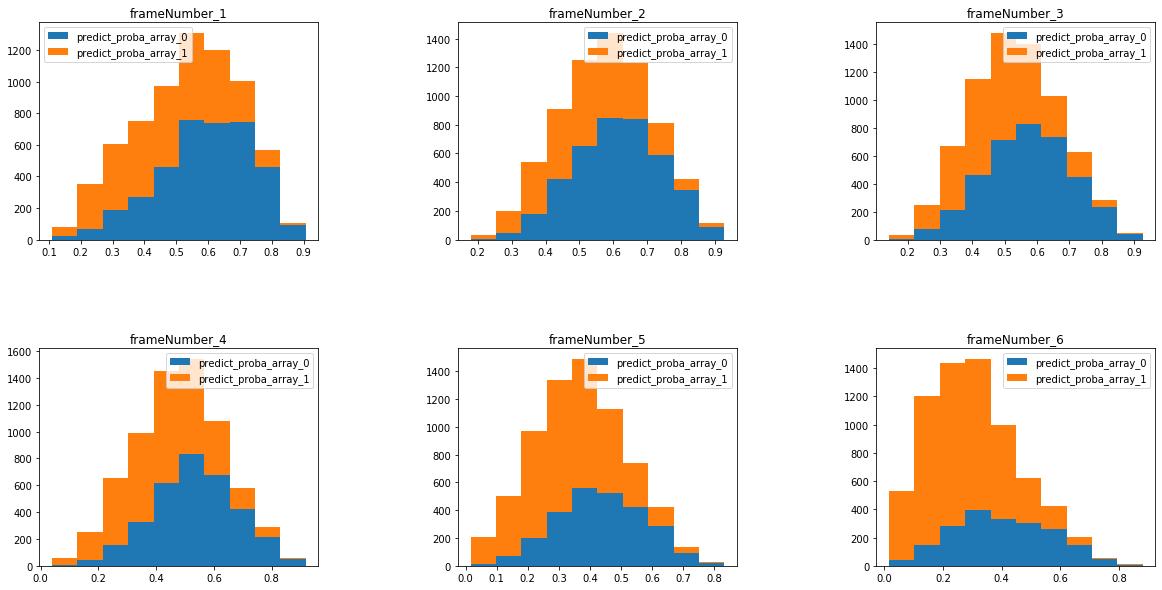

In [28]:
"""
上のセルで学習したclfを用いて色々と解析する。
今このセルで行なっている解析は
1. 各labelについて正解率を計算
2. 最適化された結果の切片および各係数を表示
3. テストデータについて、学習結果を適用した際に、ラベルが1になる確率を、実際のラベル　1 or　0で色分けしてヒストグラムを作成

"""
# 描画用の枠を用意

plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace=0.5,hspace=0.5)

# 回収率計算用に、[predict_proba_array, test_t]を各要素にもつリストを作成
predict_proba_array_list = []

# 正解率の計算などのため、train data, test dataそれぞれについて、特徴量部分のarrayとlabel部分のarrayを作成
train_x = train_data[:, :-num_labels]
test_x = test_data[:, :-num_labels]

for i, clf in enumerate(clf_list):
    train_t = train_data[:, - num_labels + i]
    test_t = test_data[:, - num_labels + i]
    
    # 正解率を計算
    train_score = clf.score(train_x, train_t)
    test_score = clf.score(test_x, test_t)
    print("{2}号艇についてtrainデータを使った正解率は{0},\n \
          testデータを使った正解率は{1}".format(train_score, test_score, i + 1))

    # テストデータについて、学習結果を適用した際に、ラベルが1になる確率を、実際のラベル　1 or　0で色分けしてヒストグラムを作成
    predict_proba_array = clf.predict_proba(test_x)
    
    # listに格納しておく
    predict_proba_array_list.append(predict_proba_array[:, 1])

    # 結果が1 (1枠が一着 , 2枠以降が3着以内) だったものの推定確率
    predict_proba_array_1 = predict_proba_array[:, 1][test_t==1]

    # 結果が0 (1枠以外が一着, 1枠以外の場合は4着以降) だったものの推定確率
    predict_proba_array_0 = predict_proba_array[:, 1][test_t==0]

    # 積み上げヒストグラムを作成
    title = "frameNumber_{0}".format(i + 1)
    labels = {'predict_proba_array_1', 'predict_proba_array_0'}
    plt.subplot(2, 3, i+1)
    plt.hist([predict_proba_array_1, predict_proba_array_0], histtype="barstacked", label=labels)
    plt.title(title)
    plt.legend()
plt.show()

### Random Forest 最適なパラメータさがし
- n_estimator...500くらいで十分


/Users/grice/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/grice/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/grice/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes curren

/Users/grice/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/grice/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/grice/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes curren

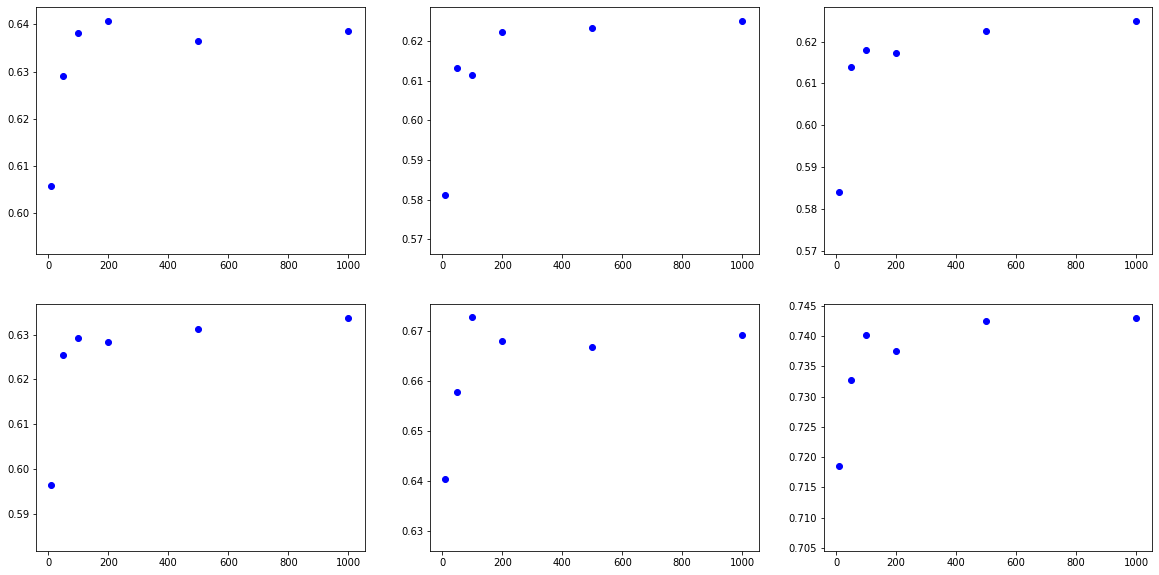

In [45]:
num_estimators_list = [10, 50, 100, 200, 500, 1000]
max_depth = None
max_features = None

# 1つ目の要素に一号艇について、２つ目のリストは二号ていについての結果を、各num_estimatorsの値について格納していく

plt.figure(figsize=(20, 10))

for num_estimators in num_estimators_list:
    clf_list, num_labels = learn_logistic_regression(train_data, column_list_label, num_estimators, max_depth, max_features)
    # 正解率の計算などのため、train data, test dataそれぞれについて、特徴量部分のarrayとlabel部分のarrayを作成
    train_x = train_data[:, :-num_labels]
    test_x = test_data[:, :-num_labels]

    for i, clf in enumerate(clf_list):
        train_t = train_data[:, - num_labels + i]
        test_t = test_data[:, - num_labels + i]

        # 正解率を計算
        train_score = clf.score(train_x, train_t)
        test_score = clf.score(test_x, test_t)
        
        plt.subplot(2, 3, i+1)
        # plt.scatter(num_estimators, train_score, c="red")
        plt.scatter(num_estimators, test_score, c="blue")

plt.show()

/Users/grice/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/grice/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/grice/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes curren

/Users/grice/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/grice/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/grice/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes curren

/Users/grice/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/grice/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/grice/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes curren

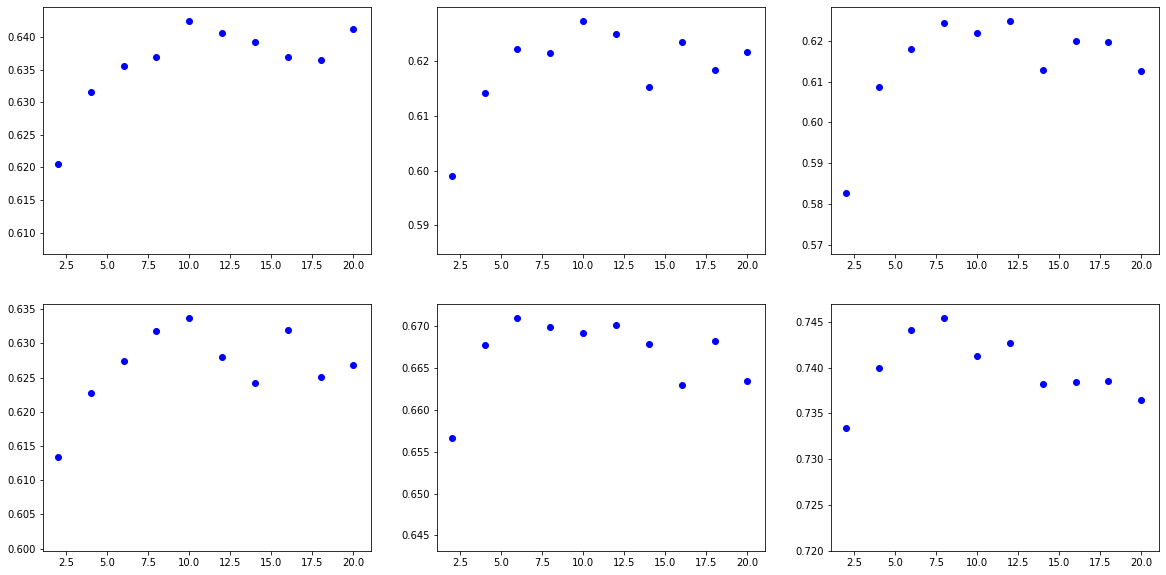

In [46]:
num_estimators = 100
max_depth_list = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
max_features = None

# 1つ目の要素に一号艇について、２つ目のリストは二号ていについての結果を、各num_estimatorsの値について格納していく

plt.figure(figsize=(20, 10))

for max_depth in max_depth_list:
    clf_list, num_labels = learn_logistic_regression(train_data, column_list_label, num_estimators, max_depth, max_features)
    # 正解率の計算などのため、train data, test dataそれぞれについて、特徴量部分のarrayとlabel部分のarrayを作成
    train_x = train_data[:, :-num_labels]
    test_x = test_data[:, :-num_labels]

    for i, clf in enumerate(clf_list):
        train_t = train_data[:, - num_labels + i]
        test_t = test_data[:, - num_labels + i]

        # 正解率を計算
        train_score = clf.score(train_x, train_t)
        test_score = clf.score(test_x, test_t)
        
        plt.subplot(2, 3, i+1)
        # plt.scatter(max_depth, train_score, c="red")
        plt.scatter(max_depth, test_score, c="blue")

plt.show()

/Users/grice/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/grice/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/grice/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes curren

/Users/grice/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/grice/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/grice/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes curren

/Users/grice/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/grice/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/grice/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes curren

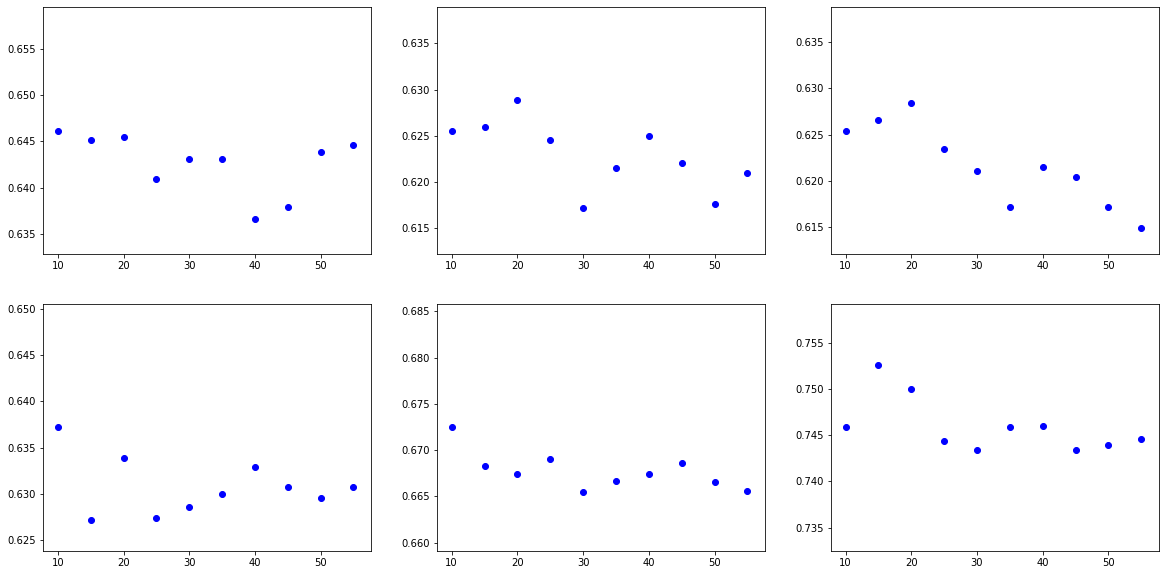

In [47]:
num_estimators = 100
max_depth = None
max_features_list = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]

# 1つ目の要素に一号艇について、２つ目のリストは二号ていについての結果を、各num_estimatorsの値について格納していく

plt.figure(figsize=(20, 10))

for max_featuresuremax_featuresax_features_list:
    clf_list, num_labels = learn_logistic_regression(train_data, column_list_label, num_estimators, max_depth, max_features)
    # 正解率の計算などのため、train data, test dataそれぞれについて、特徴量部分のarrayとlabel部分のarrayを作成
    train_x = train_data[:, :-num_labels]
    test_x = test_data[:, :-num_labels]

    for i, clf in enumerate(clf_list):
        train_t = train_data[:, - num_labels + i]
        test_t = test_data[:, - num_labels + i]

        # 正解率を計算
        train_score = clf.score(train_x, train_t)
        test_score = clf.score(test_x, test_t)
        
        plt.subplot(2, 3, i+1)
        # plt.scatter(max_depth, train_score, c="red")
        plmax_featuresturesuresturesturesres(max_features, test_score, c="blue")

plt.show()

# 考察
- 正解率はいずれのラベルに対しても6割から7割程度にとどまるが、test dataとtraining dataで同程度の正解率をだす。
確率ごとにプロットをしてみると、
- predict_probaが小さい時は実際に0ラベル、predict_probaが大きい時は実際に1ラベルであることがかなり多くなっている。
- 正解率を下げているのは実際に判断が難しいところ（0.3 < predict_proba < 0.7くらいの場所） であり、predict_probaが高いところ、低いところを抽出して用いることで十分に予測器として使用可能
- 1着以外が1位になる，荒れるレースの予測や、1着を1枠に固定し、2, 3を高いprobabilityを示すものでbox買するといったオプションが考えられる。

そこで、以下のセルにおいては掛け方を色々してみた時の回収率計算を行う。

In [11]:
# 計算用dfを作成
# 6列目までが上の解析によって求めた確率(1号艇が1位になる率, 2-6号艇が3位以内に入る確率)
# 7列目以降にオッズ関係の値を格納

for_calc_refund_rate_df = pd.DataFrame(np.vstack(predict_proba_array_list).T, columns=["PredProb_{0}".format(i) for i in range(1, 7)])
for odds_column_name in odds_list:
    # TODO intで入れられるものはintで。無理なものはとりあえずobjectのままで格納
    for_calc_refund_rate_df[odds_column_name] = fv_label_odds_df[odds_column_name][train_size:].values

print(for_calc_refund_rate_df)

      PredProb_1  PredProb_2  PredProb_3  PredProb_4  PredProb_5  PredProb_6  \
0          0.573       0.602       0.682       0.238       0.050       0.567   
1          0.794       0.779       0.332       0.471       0.219       0.263   
2          0.246       0.890       0.300       0.655       0.141       0.493   
3          0.206       0.834       0.541       0.281       0.074       0.596   
4          0.275       0.744       0.346       0.748       0.366       0.086   
5          0.515       0.413       0.660       0.637       0.278       0.220   
6          0.511       0.776       0.448       0.528       0.258       0.159   
7          0.517       0.582       0.569       0.224       0.621       0.215   
8          0.485       0.427       0.399       0.816       0.433       0.051   
9          0.473       0.548       0.451       0.524       0.355       0.350   
10         0.372       0.371       0.660       0.614       0.328       0.356   
11         0.438       0.873       0.511

In [12]:
# 確率x_1以上のときのみ、1に単勝賭けした時の回収率
x_1_list = [0.6, 0.7, 0.8]
for x_1 in x_1_list:
    bet = sum(for_calc_refund_rate_df["PredProb_1"] > x_1)

    return_boolean = (for_calc_refund_rate_df["PredProb_1"] > x_1) & (for_calc_refund_rate_df["win"] == "1")
    return_ = sum(for_calc_refund_rate_df["winOdds"][return_boolean])

    print("確率{0}以上で1に単勝betした場合、的中率は{1}, 回収率は{2}".format(x_1, sum(return_boolean) / bet, return_ / (bet * 100)))

確率0.6以上で1に単勝betした場合、的中率は0.7161314138058325, 回収率は0.9159837578442229
確率0.7以上で1に単勝betした場合、的中率は0.7785888077858881, 回収率は0.9472830494728305
確率0.8以上で1に単勝betした場合、的中率は0.856, 回収率は0.9712


In [13]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率がx_2超えがあった場合に、1-XY..の形で2連単bet

x_1_list = [0.7, 0.75, 0.8]
x_2_list = [0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        bet_num = "1-{0}".format(j)
                        bet = bet + 100
                        if row["exacta"] == bet_num:
                            income = income + row["exactaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で2連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.7以上かつ、p2-6が0.5以上で2連単betすると収益は-40690, 回収率は0.8152134423251589
p1が0.7以上かつ、p2-6が0.6以上で2連単betすると収益は-15560, 回収率は0.8555246053853296
p1が0.7以上かつ、p2-6が0.7以上で2連単betすると収益は-5140, 回収率は0.8501457725947522
p1が0.7以上かつ、p2-6が0.8以上で2連単betすると収益は-760, 回収率は0.8538461538461538
p1が0.75以上かつ、p2-6が0.5以上で2連単betすると収益は-18040, 回収率は0.8312441534144059
p1が0.75以上かつ、p2-6が0.6以上で2連単betすると収益は-10310, 回収率は0.8135623869801085
p1が0.75以上かつ、p2-6が0.7以上で2連単betすると収益は-3290, 回収率は0.8076023391812865
p1が0.75以上かつ、p2-6が0.8以上で2連単betすると収益は-510, 回収率は0.796
p1が0.8以上かつ、p2-6が0.5以上で2連単betすると収益は-7810, 回収率は0.8183720930232559
p1が0.8以上かつ、p2-6が0.6以上で2連単betすると収益は-5510, 回収率は0.7484018264840183
p1が0.8以上かつ、p2-6が0.7以上で2連単betすると収益は-1680, 回収率は0.72
p1が0.8以上かつ、p2-6が0.8以上で2連単betすると収益は-320, 回収率は0.68


In [14]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2超えがあった場合に、1-X-9と1-9-Xの形で3連単bet
x_1_list = [0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j:
                                bet = bet + 200
                                bet_num_1 = "1-{0}-{1}".format(j, k)
                                bet_num_2 = "1-{0}-{1}".format(k, j)
                                # print(bet_num_1, bet_num_2, row["trifecta"], row["trifectaOdds"])
                                if row["trifecta"] == bet_num_1 or row["trifecta"] == bet_num_2:
                                    income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は-352410, 回収率は0.8179700413223141
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は-87180, 回収率は0.8611783439490446
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は-9000, 回収率は0.9172794117647058
p1が0.7以上かつ、p2-6が0.6以上で3連単betすると収益は-174520, 回収率は0.7974466109563603
p1が0.7以上かつ、p2-6が0.7以上で3連単betすると収益は-56900, 回収率は0.7926384839650146
p1が0.7以上かつ、p2-6が0.8以上で3連単betすると収益は-6370, 回収率は0.846875
p1が0.8以上かつ、p2-6が0.6以上で3連単betすると収益は-20200, 回収率は0.884703196347032
p1が0.8以上かつ、p2-6が0.7以上で3連単betすると収益は-10240, 回収率は0.7866666666666666
p1が0.8以上かつ、p2-6が0.8以上で3連単betすると収益は1980, 回収率は1.2475


In [15]:
# 上と同じノリで2着固定。すなわち、
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2超えがあった場合に、1-X-9の形で3連単bet
x_1_list = [0.5, 0.6, 0.7, 0.8]
x_2_list = [0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j:
                                bet = bet + 100
                                bet_num = "1-{0}-{1}".format(j, k)
                                if row["trifecta"] == bet_num:
                                    income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.5以上かつ、p2-6が0.4以上で3連単betすると収益は-1239320, 回収率は0.7585677550066235
p1が0.5以上かつ、p2-6が0.5以上で3連単betすると収益は-824910, 回収率は0.7500878574890936
p1が0.5以上かつ、p2-6が0.6以上で3連単betすると収益は-343610, 回収率は0.7858327100473698
p1が0.5以上かつ、p2-6が0.7以上で3連単betすると収益は-108570, 回収率は0.8027434593023256
p1が0.5以上かつ、p2-6が0.8以上で3連単betすると収益は-16050, 回収率は0.8513888888888889
p1が0.6以上かつ、p2-6が0.4以上で3連単betすると収益は-743210, 回収率は0.7623705077375623
p1が0.6以上かつ、p2-6が0.5以上で3連単betすると収益は-503060, 回収率は0.7487212787212787
p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は-202740, 回収率は0.7905578512396694
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は-66880, 回収率は0.7870063694267516
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は-2400, 回収率は0.9558823529411765
p1が0.7以上かつ、p2-6が0.4以上で3連単betすると収益は-355680, 回収率は0.7411353711790393
p1が0.7以上かつ、p2-6が0.5以上で3連単betすると収益は-210950, 回収率は0.7605018165304269
p1が0.7以上かつ、p2-6が0.6以上で3連単betすると収益は-81750, 回収率は0.8102367688022284
p1が0.7以上かつ、p2-6が0.7以上で3連単betすると収益は-33650, 回収率は0.7547376093294461
p1が0.7以上かつ、p2-6が0.8以上で3連単betすると収益は-5140, 回収率は0.7528846153846154
p1が0.8以上かつ、p2-6が0

In [16]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以下が2艇以上あった場合に、1頭で、2割以下艇を外した残りを2, 3着boxにして買う
x_1_list = [0.6, 0.7, 0.8]
x_2_list = [0.4, 0.3, 0.2]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                outers = (row[["PredProb_{0}".format(n) for n in range(2, 7)]] < x_2)
                num_outers = sum(outers)
                if (num_outers > 1):
                    for j in range(2, 7):
                        if row["PredProb_{0}".format(j)] > x_2:
                            for k in range(2, 7):
                                if k is not j and row["PredProb_{0}".format(k)] > x_2:
                                    bet = bet + 100
                                    bet_num = "1-{0}-{1}".format(j, k)
                                    if row["trifecta"] == bet_num:
                                        income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.6以上かつ、p2-6が0.4以上で3連単betすると収益は-192290, 回収率は0.8225124607716449
p1が0.6以上かつ、p2-6が0.3以上で3連単betすると収益は-76400, 回収率は0.8470164197036444
p1が0.6以上かつ、p2-6が0.2以上で3連単betすると収益は880, 回収率は1.0138801261829653
p1が0.7以上かつ、p2-6が0.4以上で3連単betすると収益は-95080, 回収率は0.8099920063948841
p1が0.7以上かつ、p2-6が0.3以上で3連単betすると収益は-46970, 回収率は0.8333215046132009
p1が0.7以上かつ、p2-6が0.2以上で3連単betすると収益は-5070, 回収率は0.8559659090909091
p1が0.8以上かつ、p2-6が0.4以上で3連単betすると収益は-15200, 回収率は0.848605577689243
p1が0.8以上かつ、p2-6が0.3以上で3連単betすると収益は-11310, 回収率は0.8275914634146342
p1が0.8以上かつ、p2-6が0.2以上で3連単betすると収益は-2030, 回収率は0.8009803921568628


In [17]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以上が2艇以上あった場合に、1頭で、x_2以上艇を2, 3着boxにして買う
x_1_list = [0.5, 0.6, 0.7, 0.75, 0.8]
x_2_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j and row["PredProb_{0}".format(k)] > x_2:
                                bet = bet + 100
                                bet_num = "1-{0}-{1}".format(j, k)
                                if row["trifecta"] == bet_num:
                                    income = income + row["trifectaOdds"]
                                # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("投票候補なし")

p1が0.5以上かつ、p2-6が0.3以上で3連単betすると収益は-1071690, 回収率は0.7890207890385069
p1が0.5以上かつ、p2-6が0.4以上で3連単betすると収益は-540200, 回収率は0.8027171134321818
p1が0.5以上かつ、p2-6が0.5以上で3連単betすると収益は-170200, 回収率は0.8178900064198588
p1が0.5以上かつ、p2-6が0.6以上で3連単betすると収益は-18580, 回収率は0.890962441314554
p1が0.5以上かつ、p2-6が0.7以上で3連単betすると収益は-7670, 回収率は0.4360294117647059
p1が0.5以上かつ、p2-6が0.8以上で3連単betすると収益は-90, 回収率は0.85
p1が0.6以上かつ、p2-6が0.3以上で3連単betすると収益は-580670, 回収率は0.808207821376668
p1が0.6以上かつ、p2-6が0.4以上で3連単betすると収益は-314760, 回収率は0.8026830491474424
p1が0.6以上かつ、p2-6が0.5以上で3連単betすると収益は-96820, 回収率は0.8203710575139147
p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は-8950, 回収率は0.9084867075664622
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は-3610, 回収率は0.54875
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は310, 回収率は2.55
p1が0.7以上かつ、p2-6が0.3以上で3連単betすると収益は-193320, 回収率は0.8456896551724138
p1が0.7以上かつ、p2-6が0.4以上で3連単betすると収益は-128940, 回収率は0.8062218214607755
p1が0.7以上かつ、p2-6が0.5以上で3連単betすると収益は-35150, 回収率は0.8441932624113475
p1が0.7以上かつ、p2-6が0.6以上で3連単betすると収益は-5760, 回収率は0.8615384615384616
p1が

In [18]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以上が1艇, X_3以上が1艇以上あった場合に、1頭で、x_2以上艇を2, 3着boxにして買う
# ただし、2-6号艇のうち二つ以上の艇がx_２を超えていた場合、それらに対しては2倍のbet額になるアルゴリズムになっている
x_1_list = [0.6, 0.7, 0.75, 0.8]
x_2_list = [0.6, 0.7, 0.8]
x_3_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        for x_3 in x_3_list:
            if x_3 <= x_2:

                income = 0
                bet = 0

                for index, row in for_calc_refund_rate_df.iterrows():
                    if (row["PredProb_1"] > x_1):
                        for j in range(2, 7):
                            if row["PredProb_{0}".format(j)] > x_2:
                                for k in range(2, 7):
                                    if k is not j and row["PredProb_{0}".format(k)] > x_3:
                                        bet = bet + 200
                                        bet_num_1 = "1-{0}-{1}".format(j, k)
                                        bet_num_2 = "1-{0}-{1}".format(k, j)

                                        if row["trifecta"] == bet_num_1 or row["trifecta"] == bet_num_2:
                                            income = income + row["trifectaOdds"]
                                        # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
                try:
                    text = "p1が{0}以上かつ、p2が{1}以上かつp3が{2}で3連単betすると収益は{3}, 回収率は{4}".format(x_1, x_2, x_3, income-bet, income/bet)
                    if (income / bet) < 1:
                        text = termcolor.colored(text, "red")
                    print(text)
                except ZeroDivisionError:
                    print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.6以上かつ、p2が0.6以上かつp3が0.3で3連単betすると収益は-224270, 回収率は0.8192245687570531
p1が0.6以上かつ、p2が0.6以上かつp3が0.4で3連単betすると収益は-118370, 回収率は0.857351168956375
p1が0.6以上かつ、p2が0.6以上かつp3が0.5で3連単betすると収益は-60560, 回収率は0.8667839859216894
p1が0.6以上かつ、p2が0.6以上かつp3が0.6で3連単betすると収益は-17900, 回収率は0.9084867075664622
p1が0.6以上かつ、p2が0.7以上かつp3が0.3で3連単betすると収益は-43080, 回収率は0.8833152762730228
p1が0.6以上かつ、p2が0.7以上かつp3が0.4で3連単betすると収益は-21590, 回収率は0.9082057823129251
p1が0.6以上かつ、p2が0.7以上かつp3が0.5で3連単betすると収益は-14470, 回収率は0.8827390599675851
p1が0.6以上かつ、p2が0.7以上かつp3が0.6で3連単betすると収益は-3300, 回収率は0.9386617100371747
p1が0.6以上かつ、p2が0.7以上かつp3が0.7で3連単betすると収益は-7220, 回収率は0.54875
p1が0.6以上かつ、p2が0.8以上かつp3が0.3で3連単betすると収益は-7500, 回収率は0.8665480427046264
p1が0.6以上かつ、p2が0.8以上かつp3が0.4で3連単betすると収益は4980, 回収率は1.1464705882352941
p1が0.6以上かつ、p2が0.8以上かつp3が0.5で3連単betすると収益は220, 回収率は1.0135802469135802
p1が0.6以上かつ、p2が0.8以上かつp3が0.6で3連単betすると収益は2270, 回収率は1.3242857142857143
p1が0.6以上かつ、p2が0.8以上かつp3が0.7で3連単betすると収益は480, 回収率は1.2181818181818183
p1が0.6以上かつ、p2が0.8以上かつp3が0.8で3

In [19]:
# 1号艇の勝率x_1以上,2号艇の勝率x_2以上のとき、2-1にbet
x_1_list = [0.3, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                if row["PredProb_2".format(j)] > x_2:
                    bet = bet + 100

                    if row["exacta"] == "2-1":
                        income = income + row["exactaOdds"]
                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2が{1}以上で2連単2-1にbetすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.3以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-65500, 回収率は0.7493302717183314
p1が0.3以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-28800, 回収率は0.7419354838709677
p1が0.3以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-4690, 回収率は0.8342756183745583
p1が0.6以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-36710, 回収率は0.6704667863554757
p1が0.6以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-14960, 回収率は0.626
p1が0.6以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-4540, 回収率は0.3780821917808219
p1が0.7以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-27810, 回収率は0.49436363636363634
p1が0.7以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-12530, 回収率は0.40047846889952154
p1が0.7以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-2700, 回収率は0.25
p1が0.8以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-5440, 回収率は0.5269565217391304
p1が0.8以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-2450, 回収率は0.4024390243902439
p1が0.8以上かつ、p2が0.8以上で2連単2-1にbetすると収益は300, 回収率は1.5


In [20]:
x_1_list = [0.6, 0.7, 0.75, 0.8]
x_2_list = [0.6, 0.7, 0.8]
x_3_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        for x_3 in x_3_list:
            if x_3 <= x_2:

                income = 0
                bet = 0

                for index, row in for_calc_refund_rate_df.iterrows():
                    if (row["PredProb_1"] > x_1):
                        for j in range(2, 7):
                            if row["PredProb_{0}".format(j)] > x_2:
                                for k in range(2, 7):
                                    if k is not j and row["PredProb_{0}".format(k)] > x_3:
                                        bet = bet + 200
                                        bet_num_1 = "1-{0}-{1}".format(j, k)
                                        bet_num_2 = "1-{0}-{1}".format(k, j)

                                        if row["trifecta"] == bet_num_1 or row["trifecta"] == bet_num_2:
                                            income = income + row["trifectaOdds"]
                                        # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
                try:
                    text = "p1が{0}以上かつ、p2が{1}以上かつp3が{2}で3連単betすると収益は{3}, 回収率は{4}".format(x_1, x_2, x_3, income-bet, income/bet)
                    if (income / bet) < 1:
                        text = termcolor.colored(text, "red")
                    print(text)
                except ZeroDivisionError:
                    print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.6以上かつ、p2が0.6以上かつp3が0.3で3連単betすると収益は-224270, 回収率は0.8192245687570531
p1が0.6以上かつ、p2が0.6以上かつp3が0.4で3連単betすると収益は-118370, 回収率は0.857351168956375
p1が0.6以上かつ、p2が0.6以上かつp3が0.5で3連単betすると収益は-60560, 回収率は0.8667839859216894
p1が0.6以上かつ、p2が0.6以上かつp3が0.6で3連単betすると収益は-17900, 回収率は0.9084867075664622
p1が0.6以上かつ、p2が0.7以上かつp3が0.3で3連単betすると収益は-43080, 回収率は0.8833152762730228
p1が0.6以上かつ、p2が0.7以上かつp3が0.4で3連単betすると収益は-21590, 回収率は0.9082057823129251
p1が0.6以上かつ、p2が0.7以上かつp3が0.5で3連単betすると収益は-14470, 回収率は0.8827390599675851
p1が0.6以上かつ、p2が0.7以上かつp3が0.6で3連単betすると収益は-3300, 回収率は0.9386617100371747
p1が0.6以上かつ、p2が0.7以上かつp3が0.7で3連単betすると収益は-7220, 回収率は0.54875
p1が0.6以上かつ、p2が0.8以上かつp3が0.3で3連単betすると収益は-7500, 回収率は0.8665480427046264
p1が0.6以上かつ、p2が0.8以上かつp3が0.4で3連単betすると収益は4980, 回収率は1.1464705882352941
p1が0.6以上かつ、p2が0.8以上かつp3が0.5で3連単betすると収益は220, 回収率は1.0135802469135802
p1が0.6以上かつ、p2が0.8以上かつp3が0.6で3連単betすると収益は2270, 回収率は1.3242857142857143
p1が0.6以上かつ、p2が0.8以上かつp3が0.7で3連単betすると収益は480, 回収率は1.2181818181818183
p1が0.6以上かつ、p2が0.8以上かつp3が0.8で3

In [21]:
# 1号艇の勝率x_1以上,3号艇の勝率x_2以上のとき、3-1にbet
x_1_list = [0.3, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                if row["PredProb_3".format(j)] > x_2:
                    bet = bet + 100

                    if row["exacta"] == "3-1":
                        income = income + row["exactaOdds"]
                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2が{1}以上で2連単2-1にbetすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.3以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-39640, 回収率は0.7946113989637306
p1が0.3以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-25840, 回収率は0.6536193029490617
p1が0.3以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-4050, 回収率は0.7515337423312883
p1が0.6以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-18600, 回収率は0.7621483375959079
p1が0.6以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-13730, 回収率は0.46988416988416987
p1が0.6以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-2250, 回収率は0.5408163265306123
p1が0.7以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-14320, 回収率は0.5849275362318841
p1が0.7以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-6110, 回収率は0.38282828282828285
p1が0.7以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-470, 回収率は0.6642857142857143
p1が0.8以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-3300, 回収率は0.5352112676056338
p1が0.8以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-1400, 回収率は0.0
p1が0.8以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-400, 回収率は0.0


In [22]:
# 1号艇の勝率x_1以上,4号艇の勝率x_2以上のとき、4-1にbet
x_1_list = [0.3, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                if row["PredProb_4".format(j)] > x_2:
                    bet = bet + 100

                    if row["exacta"] == "4-1":
                        income = income + row["exactaOdds"]
                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2が{1}以上で2連単2-1にbetすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.3以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-42240, 回収率は0.6826446280991736
p1が0.3以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-22160, 回収率は0.5373695198329854
p1が0.3以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-6640, 回収率は0.3676190476190476
p1が0.6以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-19640, 回収率は0.5126550868486353
p1が0.6以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-2710, 回収率は0.7467289719626168
p1が0.6以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-1400, 回収率は0.0
p1が0.7以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-12590, 回収率は0.20316455696202532
p1が0.7以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-2590, 回収率は0.23823529411764705
p1が0.7以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-200, 回収率は0.0
p1が0.8以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-1890, 回収率は0.409375
p1が0.8以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-500, 回収率は0.0
p1=0.8, p2=0.8, p3=0.8の時、投票候補なし


In [23]:
# 1号艇の勝率x_1以上,2号艇の勝率x_2以上のとき、1-2にbet
x_1_list = [0.3, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                if row["PredProb_2".format(j)] > x_2:
                    bet = bet + 100

                    if row["exacta"] == "1-2":
                        income = income + row["exactaOdds"]
                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2が{1}以上で2連単2-1にbetすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.3以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-47150, 回収率は0.8195560658247225
p1が0.3以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-15550, 回収率は0.860663082437276
p1が0.3以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-8310, 回収率は0.7063604240282686
p1が0.6以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-14230, 回収率は0.872262118491921
p1が0.6以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-4270, 回収率は0.89325
p1が0.6以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-2070, 回収率は0.7164383561643836
p1が0.7以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-3200, 回収率は0.9418181818181818
p1が0.7以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-1670, 回収率は0.9200956937799043
p1が0.7以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-450, 回収率は0.875
p1が0.8以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-1080, 回収率は0.9060869565217391
p1が0.8以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-430, 回収率は0.8951219512195122
p1が0.8以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-320, 回収率は0.4666666666666667


In [24]:
# 1号艇の勝率x_1以上,2号艇の勝率x_2以上のときで、x_3を超えている他の艇に対して2-1-XXにbet
x_1_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]
x_3_list = [0.2, 0.3, 0.4, 0.5, 0.6]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        for x_3 in x_3_list:
            income = 0
            bet = 0

            for index, row in for_calc_refund_rate_df.iterrows():
                if (row["PredProb_1"] > x_1):
                    if row["PredProb_2".format(j)] > x_2:
                        for i in range(3, 7):
                            if row["PredProb_{0}".format(i)] > x_3:
                                bet = bet + 100

                                if row["trifecta"] == "2-1-{0}".format(i):
                                    income = income + row["trifectaOdds"]
                                # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
            try:
                text = "p1 > {0}、p2 > {1}, p3 > {2}で3連単2-1-i にbetすると収益は{3}, 回収率は{4}".format(x_1, x_2, x_3, income-bet, income/bet)
                if (income / bet) < 1:
                    text = termcolor.colored(text, "red")
                print(text)
            except ZeroDivisionError:
                print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1 > 0.3、p2 > 0.6, p3 > 0.2で3連単2-1-i にbetすると収益は-232510, 回収率は0.7386647184444195
p1 > 0.3、p2 > 0.6, p3 > 0.3で3連単2-1-i にbetすると収益は-170440, 回収率は0.7579664867935245
p1 > 0.3、p2 > 0.6, p3 > 0.4で3連単2-1-i にbetすると収益は-122550, 回収率は0.7462732919254659
p1 > 0.3、p2 > 0.6, p3 > 0.5で3連単2-1-i にbetすると収益は-63510, 回収率は0.7712175792507204
p1 > 0.3、p2 > 0.6, p3 > 0.6で3連単2-1-i にbetすると収益は-35690, 回収率は0.7028309741881765
p1 > 0.3、p2 > 0.7, p3 > 0.2で3連単2-1-i にbetすると収益は-91260, 回収率は0.7496982995063083
p1 > 0.3、p2 > 0.7, p3 > 0.3で3連単2-1-i にbetすると収益は-63630, 回収率は0.7711974110032362
p1 > 0.3、p2 > 0.7, p3 > 0.4で3連単2-1-i にbetすると収益は-52170, 回収率は0.7190630048465266
p1 > 0.3、p2 > 0.7, p3 > 0.5で3連単2-1-i にbetすると収益は-28390, 回収率は0.7301330798479088
p1 > 0.3、p2 > 0.7, p3 > 0.6で3連単2-1-i にbetすると収益は-18020, 回収率は0.6107991360691145
p1 > 0.3、p2 > 0.8, p3 > 0.2で3連単2-1-i にbetすると収益は-20260, 回収率は0.7687214611872146
p1 > 0.3、p2 > 0.8, p3 > 0.3で3連単2-1-i にbetすると収益は-5990, 回収率は0.9066978193146418
p1 > 0.3、p2 > 0.8, p3 > 0.4で3連単2-1-i にbetすると収益は-10540, 回収率は0.7

### x_2 > 0.8 さえ入れればほとんどのx_1, x_3でプラスになるぞおおおおおお
### x_1 > 0.4, x_2 > 0.8, x_3 > 0.6を満たすレースへbetしていってみる探す